# Stable Diffusion & Eva

In [2]:
import os
from os import path

import pyarrow as pa
import torch
from datasets import load_dataset
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import LazyConfig, instantiate
from diffusers import AutoPipelineForText2Image
from huggingface_hub import hf_hub_download
from modelscope import AutoTokenizer
from modelscope.hub.snapshot_download import snapshot_download
from modelscope.models import Model
from modelscope.msdatasets import MsDataset
from modelscope.pipelines import pipeline
from modelscope.preprocessors import Preprocessor
from modelscope.utils.constant import Tasks
from transformers import AutoModel, LlamaModel

2024-05-03 18:20:35,777 - modelscope - INFO - PyTorch version 2.2.2+cu118 Found.
2024-05-03 18:20:35,778 - modelscope - INFO - Loading ast index from /mnt/workspace/.cache/modelscope/ast_indexer
2024-05-03 18:20:35,804 - modelscope - INFO - Loading done! Current index file version is 1.14.0, with md5 636cb37b3e5f290e6e650de7d45b396c and a total number of 976 components indexed


In [3]:
# 拉取到本地
base_url = r'/mnt/workspace'
ckpt_base_pth = path.join(base_url, 'model')
sd_id = r'AI-ModelScope/stable-diffusion-2-1'
sd_path = os.path.join(ckpt_base_pth, sd_id)

In [4]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
# device_map = '0'
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
# from_pretrained_dict = {'device_map': device_map, 'torch_dtype' : torch_dtype, 'revision': 'v1.0.1'}
from_pretrained_dict = {'torch_dtype' : torch_dtype,  'variant': 'fp16'}

def prompt_tensors_to_cuda(token_tensors):
    for k, v in token_tensors.items():
        token_tensors[k] = v.to('cuda')
    return token_tensors

In [5]:
# sd pipeline
sd_pipeline = AutoPipelineForText2Image.from_pretrained(sd_path, **from_pretrained_dict).to('cuda')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/envs/eva/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [18]:
from diffusers_interpret import StableDiffusionPipelineExplainer

explainer = StableDiffusionPipelineExplainer(sd_pipeline)
prompt = "A cat sits on the chair"
with torch.autocast('cuda'):
    output = explainer(
        prompt, 
        num_inference_steps=50,
        n_last_diffusion_steps_to_consider_for_attributions = 2
    )

  0%|          | 0/50 [00:00<?, ?it/s]

Calculating token attributions... Done!


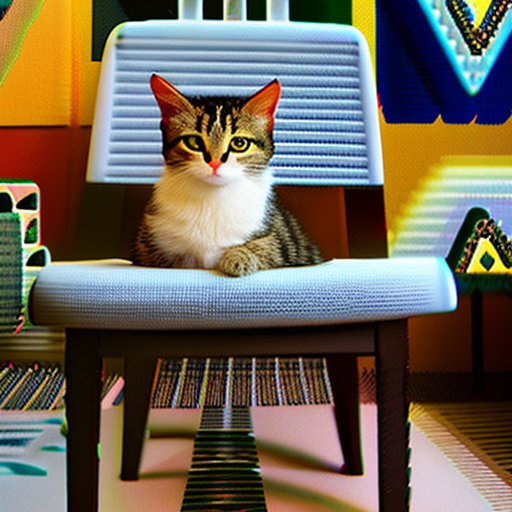

In [19]:
output.image

In [20]:
output.token_attributions

[('a', 103.09814),
 ('cat', 103.253494),
 ('sits', 27.39124),
 ('on', 17.231163),
 ('the', 12.0489025),
 ('chair', 18.020782)]